# Analyse für die Projektvereinbarung

## Imports

In [14]:
from pathlib import Path

import helpers.set_path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

## Data

In [15]:
df_labels = pd.read_csv(Path('../data/processed/train_labels.csv'))
df_labels.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
df_labels_grouped = df_labels.sum().reset_index()
df_labels_grouped.columns = ['class', 'count']
df_labels_grouped = df_labels_grouped.drop(0)
df_labels_grouped = df_labels_grouped.sort_values(by='count', ascending=False)
df_labels_grouped

,class,count
7,monkey_prosimian,2492.0
1,antelope_duiker,2474.0
4,civet_genet,2423.0
6,leopard,2254.0
3,blank,2213.0
8,rodent,2013.0
2,bird,1641.0
5,hog,978.0


## Plots

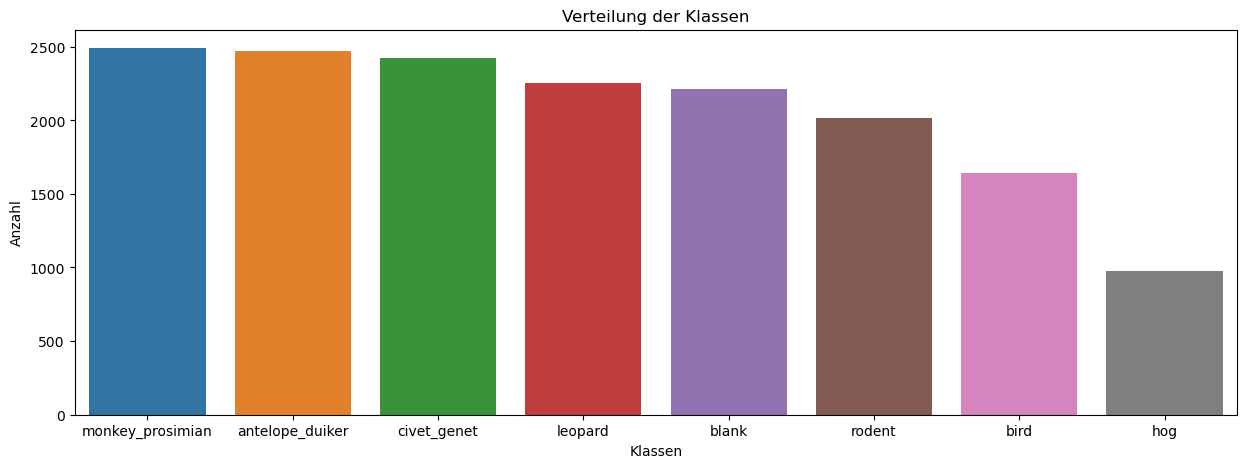

In [17]:
plt.figure(figsize=(15, 5))
sns.barplot(x='class', y='count', data=df_labels_grouped)
plt.xlabel('Klassen')
plt.ylabel('Anzahl')
plt.title('Verteilung der Klassen')
plt.show()

In [18]:
train_features = pd.read_csv(Path('../data/processed/train_features.csv'))
train_features.head()

,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000003,train_features/ZJ000003.jpg,S0008
4,ZJ000004,train_features/ZJ000004.jpg,S0036


In [19]:
dims = []

for feature in train_features.to_dict('records'):
    image = Image.open(Path(f"../data/processed/{feature['filepath']}"))
    dims.append({'x': image.size[0], 'y': image.size[1]})

dims_df = pd.DataFrame(dims)
dims_df.head()

,x,y
0,960,540
1,960,540
2,640,360
3,640,360
4,640,335


<Axes: ylabel='Frequency'>

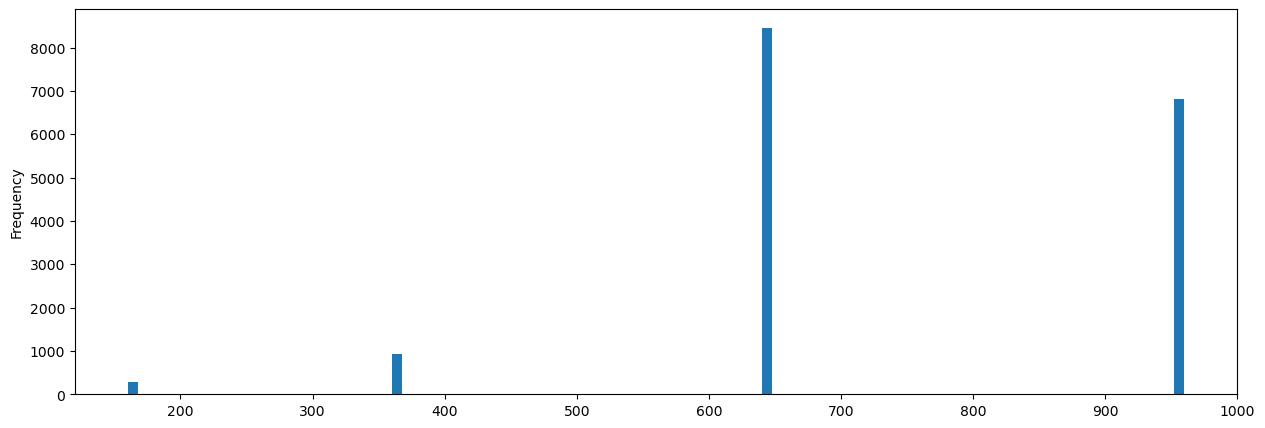

In [20]:
dims_df.x.plot(kind='hist', bins=100, figsize=(15, 5))

<Axes: ylabel='Frequency'>

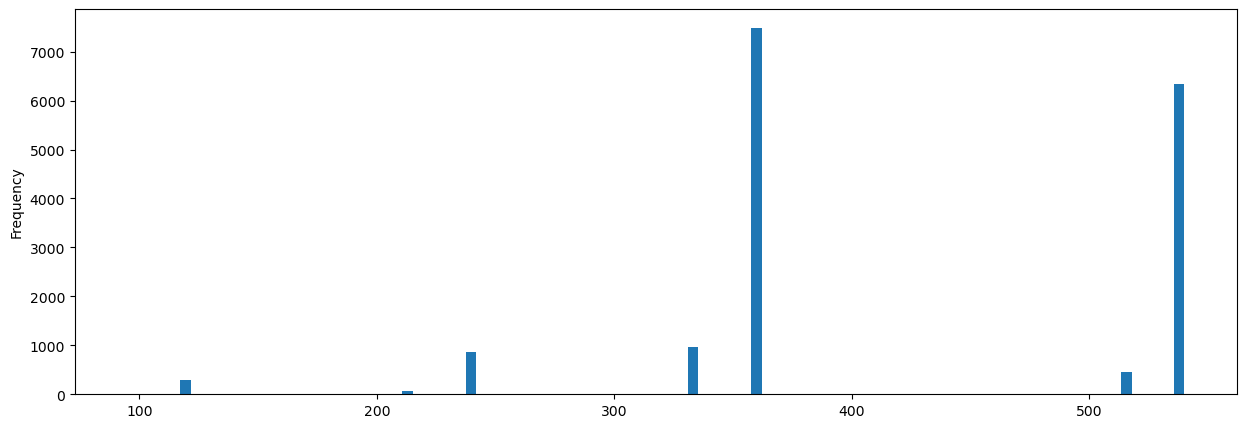

In [21]:
dims_df.y.plot(kind='hist', bins=100, figsize=(15, 5))

## Analyse der Verteilung der Anzahl Klassen pro Site

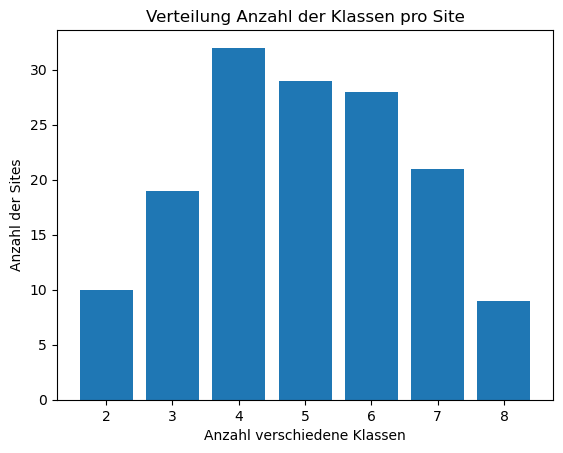

In [22]:
df = pd.merge(df_labels, train_features, on='id')

class_distribution = df.groupby('site').sum(numeric_only=True).reset_index()
class_distribution

animal_counts = class_distribution.iloc[:, 1:].nunique(axis=1)

site_counts = animal_counts.value_counts().sort_index()

plt.bar(site_counts.index, site_counts.values)
plt.xlabel('Anzahl verschiedene Klassen')
plt.ylabel('Anzahl der Sites')
plt.title('Verteilung Anzahl der Klassen pro Site')

plt.show()

## Überprüfung der Bildergrössen

In [23]:
dims = []

for feature in train_features.to_dict('records'):
    image = Image.open(Path(f"../data/processed/{feature['filepath']}"))
    dims.append({'x': image.size[0], 'y': image.size[1]})

dims_df = pd.DataFrame(dims)
dims_df.head()

,x,y
0,960,540
1,960,540
2,640,360
3,640,360
4,640,335


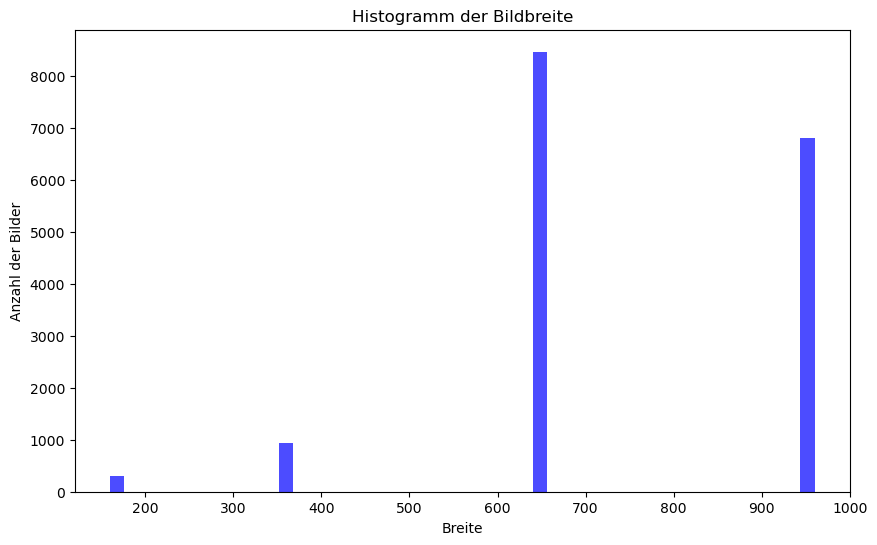

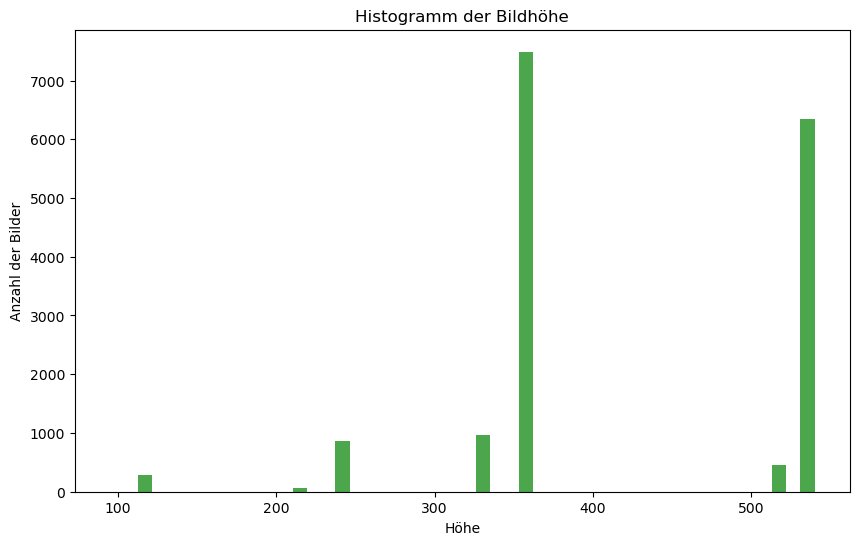

In [24]:
plt.figure(figsize=(10,6))
plt.hist(dims_df['x'], bins=50, color='blue', alpha=0.7)
plt.title('Histogramm der Bildbreite')
plt.xlabel('Breite')
plt.ylabel('Anzahl der Bilder')
plt.show()

plt.figure(figsize=(10,6))
plt.hist(dims_df['y'], bins=50, color='green', alpha=0.7)
plt.title('Histogramm der Bildhöhe')
plt.xlabel('Höhe')
plt.ylabel('Anzahl der Bilder')
plt.show()

## Überprüfung der Bilderfarben

In [25]:
image_modes = {}

for feature in train_features.to_dict('records'):
    image = Image.open(Path(f"../data/processed/{feature['filepath']}"))
    
    if image.mode in image_modes:
        image_modes[image.mode] += 1
    else:
        image_modes[image.mode] = 1

for mode, count in image_modes.items():
    print(f"Modus: {mode}, Anzahl der Bilder: {count}")

Modus: RGB, Anzahl der Bilder: 14291
Modus: L, Anzahl der Bilder: 2197


## Histogramme der Bilderfarben (L in RGB umgewandelt)

### Überprüfung aller Bilder

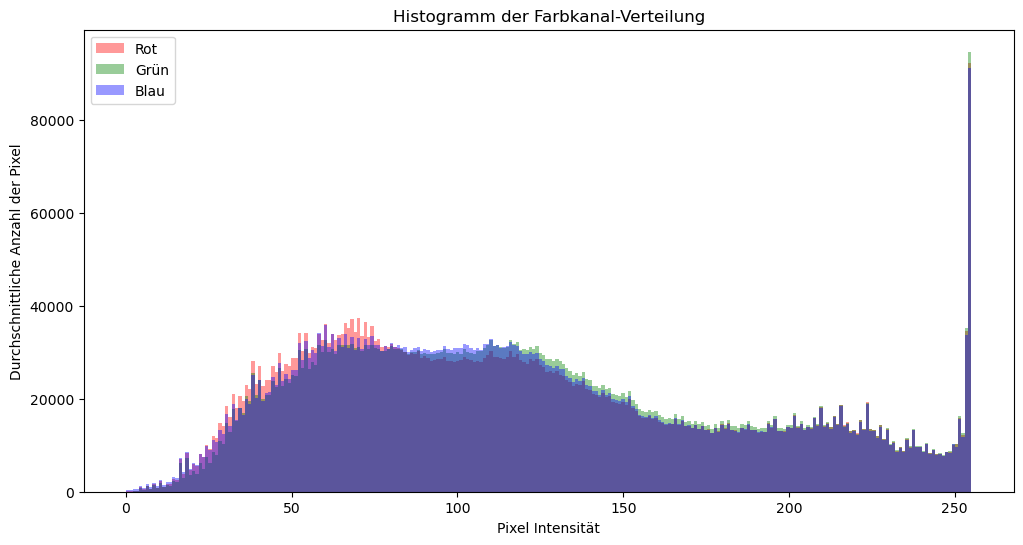

In [26]:
images_np = np.stack([
    np.array(Image.open(Path(f"../data/processed/{img['filepath']}")).convert("RGB").resize((224, 224)))
    for img in train_features[:100].to_dict('records')])

red_channel = images_np[:, :, :, 0].flatten()
green_channel = images_np[:, :, :, 1].flatten()
blue_channel = images_np[:, :, :, 2].flatten()

plt.figure(figsize=(12, 6))
plt.hist(red_channel, bins=256, color='red', alpha=0.4, label='Red Channel')
plt.hist(green_channel, bins=256, color='green', alpha=0.4, label='Green Channel')
plt.hist(blue_channel, bins=256, color='blue', alpha=0.4, label='Blue Channel')

plt.title('Histogramm der Farbkanal-Verteilung')
plt.xlabel('Pixel Intensität')
plt.ylabel('Durchschnittliche Anzahl der Pixel')
plt.legend(['Rot', 'Grün', 'Blau'])
plt.show()

### Überprüfung eines umgewandelten Bildes

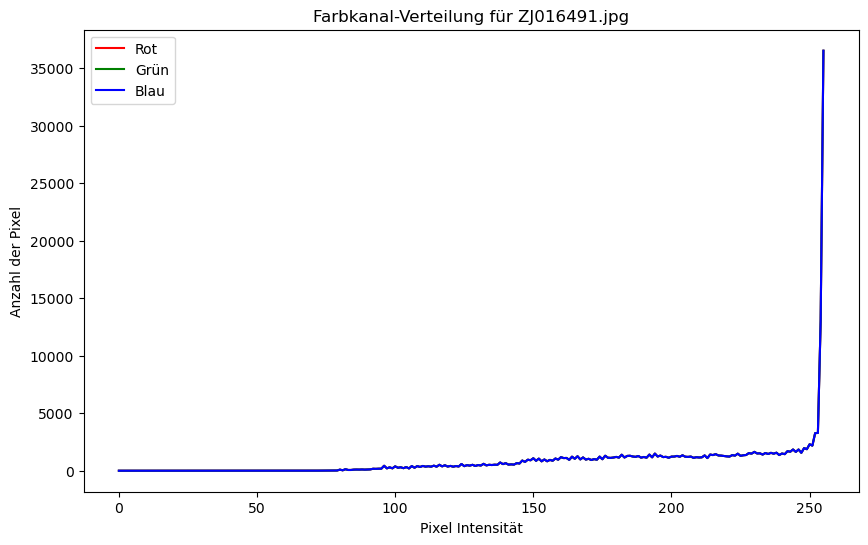

In [27]:
image = Image.open(Path(f"../data/processed/test_features/ZJ016491.jpg"))
if image.mode == 'L':
    image = image.convert("RGB")

r, g, b = image.split()

r_hist = np.histogram(r, bins=256, range=(0, 256))[0]
g_hist = np.histogram(g, bins=256, range=(0, 256))[0]
b_hist = np.histogram(b, bins=256, range=(0, 256))[0]

plt.figure(figsize=(10,6))

plt.plot(r_hist, color='red')
plt.plot(g_hist, color='green')
plt.plot(b_hist, color='blue')

plt.title('Farbkanal-Verteilung für ZJ016491.jpg')
plt.xlabel('Pixel Intensität')
plt.ylabel('Anzahl der Pixel')
plt.legend(['Rot', 'Grün', 'Blau'])

plt.show()


### Überprüfung von drei RGB Bildern

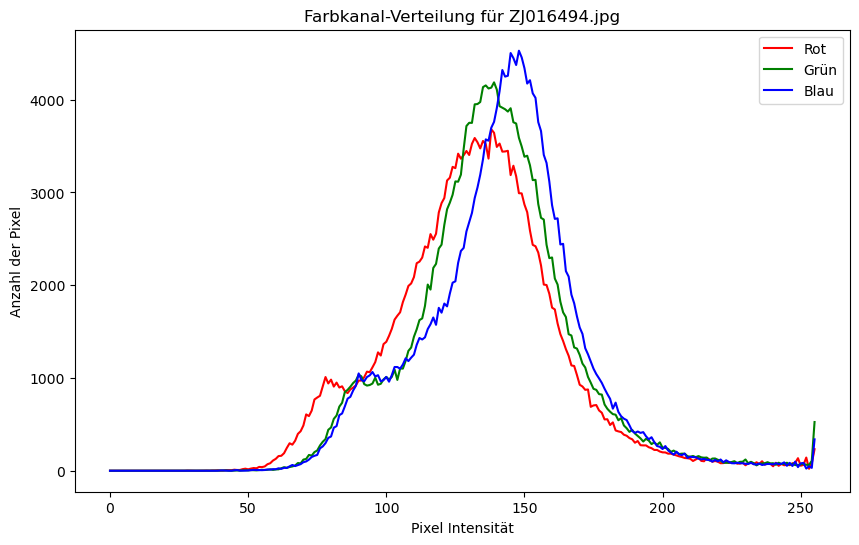

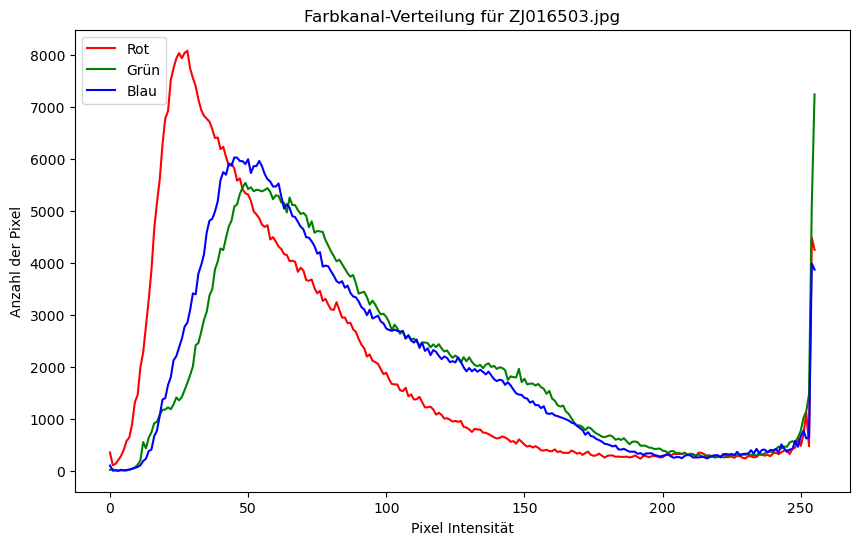

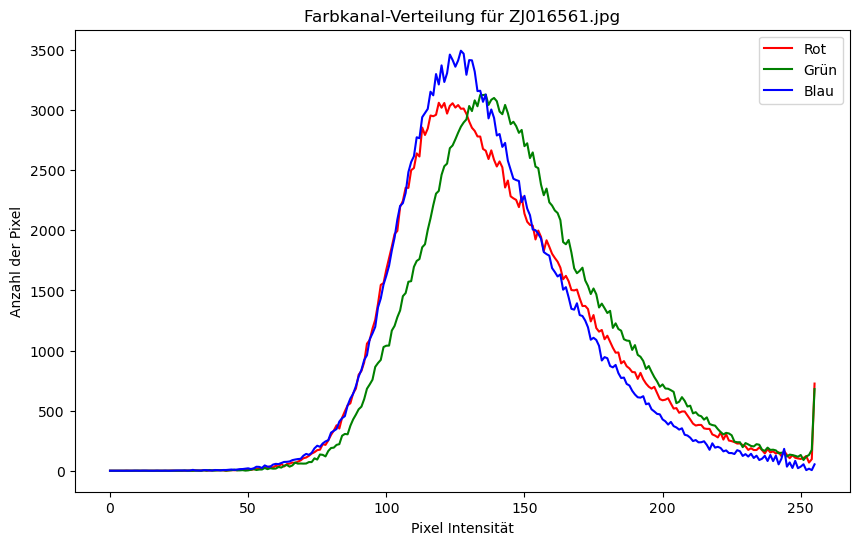

In [28]:
image_filenames = ["ZJ016494.jpg", "ZJ016503.jpg", "ZJ016561.jpg"]

for filename in image_filenames:
    image = Image.open(Path(f"../data/processed/test_features/{filename}"))

    if image.mode == 'RGB':
        r, g, b = image.split()

        r_hist = np.histogram(r, bins=256, range=(0, 256))[0]
        g_hist = np.histogram(g, bins=256, range=(0, 256))[0]
        b_hist = np.histogram(b, bins=256, range=(0, 256))[0]

        plt.figure(figsize=(10,6))

        plt.plot(r_hist, color='red')
        plt.plot(g_hist, color='green')
        plt.plot(b_hist, color='blue')

        plt.title(f'Farbkanal-Verteilung für {filename}')
        plt.xlabel('Pixel Intensität')
        plt.ylabel('Anzahl der Pixel')
        plt.legend(['Rot', 'Grün', 'Blau'])

        plt.show()
    else:
        print(f"Das Bild {filename} ist kein RGB-Bild und wird übersprungen.")


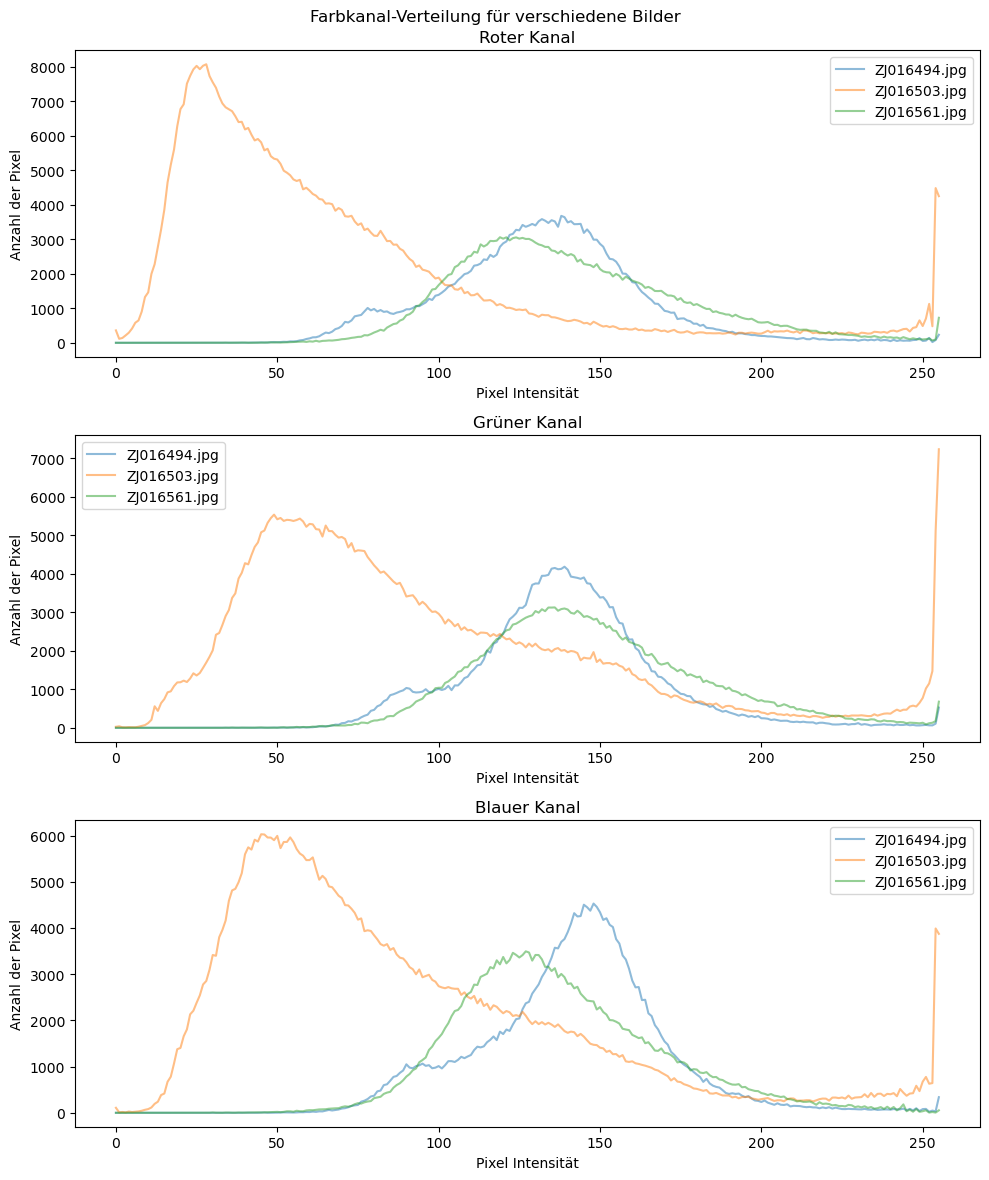

In [29]:
image_filenames = ["ZJ016494.jpg", "ZJ016503.jpg", "ZJ016561.jpg"]

r_hist_list = []
g_hist_list = []
b_hist_list = []

for filename in image_filenames:
    image = Image.open(Path(f"../data/processed/test_features/{filename}"))

    if image.mode == 'RGB':
        r, g, b = image.split()

        r_hist_list.append(np.histogram(r, bins=256, range=(0, 256))[0])
        g_hist_list.append(np.histogram(g, bins=256, range=(0, 256))[0])
        b_hist_list.append(np.histogram(b, bins=256, range=(0, 256))[0])

    else:
        print(f"Das Bild {filename} ist kein RGB-Bild und wird übersprungen.")

fig, axs = plt.subplots(3, figsize=(10,12))

for i, filename in enumerate(image_filenames):
    axs[0].plot(r_hist_list[i], alpha=0.5)
axs[0].set_title('Roter Kanal')
axs[0].set_xlabel('Pixel Intensität')
axs[0].set_ylabel('Anzahl der Pixel')
axs[0].legend(image_filenames)

for i, filename in enumerate(image_filenames):
    axs[1].plot(g_hist_list[i], alpha=0.5)
axs[1].set_title('Grüner Kanal')
axs[1].set_xlabel('Pixel Intensität')
axs[1].set_ylabel('Anzahl der Pixel')
axs[1].legend(image_filenames)

for i, filename in enumerate(image_filenames):
    axs[2].plot(b_hist_list[i], alpha=0.5)
axs[2].set_title('Blauer Kanal')
axs[2].set_xlabel('Pixel Intensität')
axs[2].set_ylabel('Anzahl der Pixel')
axs[2].legend(image_filenames)

fig.suptitle('Farbkanal-Verteilung für verschiedene Bilder')

plt.tight_layout()
plt.show()
